Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
            #print(word)
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[0:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'anarchism', 'a', 'originated', 'as', 'of', 'term']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
            labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.678456
Nearest to to: univac, bois, nirvana, polypeptide, depositing, stimulate, snow, subdue,
Nearest to were: powerful, outweighed, systematics, asin, rosenbaum, cottage, friars, pickard,
Nearest to if: investigation, javascript, behaved, nation, rotation, gland, mathematics, conservatorio,
Nearest to during: auguste, jackie, castles, symmetrically, nea, coasts, enters, vaccination,
Nearest to eight: compressor, fainting, dried, melchizedek, taps, uber, ala, implosive,
Nearest to s: wisconsin, offenders, superintendent, switches, reaches, eocene, einer, royalist,
Nearest to after: misdemeanors, decreases, unconvinced, cornish, inefficiencies, allegations, larch, wasted,
Nearest to six: spake, flakes, dorne, rendition, wallpapers, necklace, neuter, fetus,
Nearest to up: diarrhoea, erosion, tracey, gauls, aborigines, lajos, simd, discerning,
Nearest to there: americas, chanted, dear, workhorse, khartoum, bs, amphetamine, jair,
Nearest to only: bohe

Average loss at step 52000: 3.429038
Average loss at step 54000: 3.421236
Average loss at step 56000: 3.437330
Average loss at step 58000: 3.396332
Average loss at step 60000: 3.393349
Nearest to to: would, posits, athelstan, will, must, linkages, could, keswick,
Nearest to were: are, was, have, including, had, although, those, been,
Nearest to if: when, where, although, though, dissatisfied, but, before, since,
Nearest to during: after, in, when, before, following, until, under, although,
Nearest to eight: six, nine, seven, four, five, three, zero, two,
Nearest to s: deg, whose, locks, rowers, offenders, averages, undp, mindstorms,
Nearest to after: before, during, when, while, until, over, uplift, upon,
Nearest to six: eight, four, five, nine, seven, three, zero, two,
Nearest to up: out, them, him, off, diarrhoea, simd, down, discerning,
Nearest to there: they, it, he, now, still, equilibria, this, we,
Nearest to only: characterize, first, exactly, given, natively, agencies, does, no

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

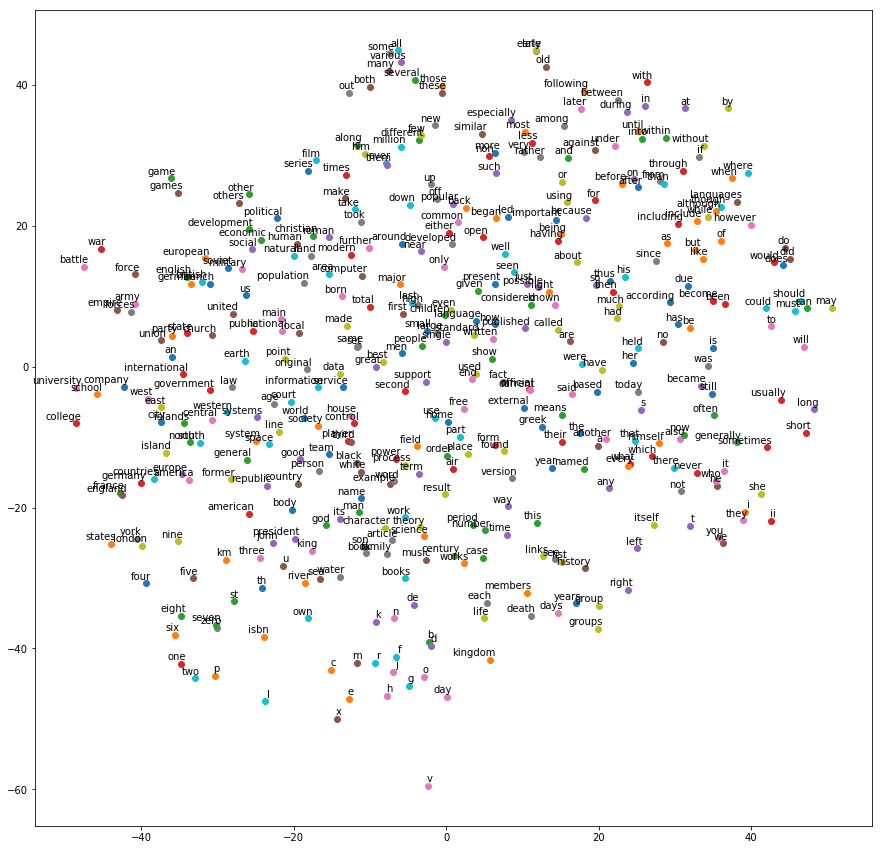

In [9]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

#### Generate Continous Bag of Words batch

In [10]:
data_index = 0

def CBOW_generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size,num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        labels[i, 0] = buffer[skip_window]
        for j in range(num_skips):
            if (j<skip_window):   #words to left of target
                batch[i ,j] = buffer[j]
            else:                 #words to right of target
                batch[i ,j] = buffer[j+1]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[0:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = CBOW_generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [[reverse_dictionary[xx] for xx in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size,num_skips])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # reduce the embeddings surrounding the target word
    embed_sum = tf.reduce_sum(embed, 1)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_sum,
            labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(2.5).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 300001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = CBOW_generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.941676
Nearest to first: manatus, waking, found, sending, environs, zombies, anjiro, waltzes,
Nearest to had: suggestibility, hammadi, rob, buddhahood, scaling, riyadh, minicomputers, premiers,
Nearest to which: engelbart, oasis, readmitted, pause, fads, evacuating, t, undermines,
Nearest to was: micrometres, greenpeace, elevations, coupon, sensations, strongly, fundamentalism, varna,
Nearest to will: cuauht, watching, goblin, oscillation, danubian, zoroaster, symmetric, vive,
Nearest to an: catacomb, seasoned, damon, tenant, blameless, counterclockwise, dissuade, belladonna,
Nearest to time: snowmobiles, vibrato, incunabula, monocots, puncture, voyage, kor, neptunian,
Nearest to after: livelihoods, aldrin, rabelais, abdu, culminate, predictable, togo, crossbows,
Nearest to on: expositor, comically, bofors, siena, accounting, felony, rejoined, fanzines,
Nearest to with: congolese, hernandez, swan, harbin, tadeusz, campuses, forestry, safely,
Neares

Average loss at step 52000: 2.939753
Average loss at step 54000: 2.906155
Average loss at step 56000: 2.912093
Average loss at step 58000: 2.800414
Average loss at step 60000: 2.885896
Nearest to first: second, last, next, third, ets, biggest, fourth, latest,
Nearest to had: has, have, was, tried, gradually, refused, wanted, having,
Nearest to which: typically, that, what, also, it, hadrons, manorial, who,
Nearest to was: is, had, has, became, were, appears, remained, westinghouse,
Nearest to will: can, would, could, shall, should, might, must, cannot,
Nearest to an: rgen, fro, nisan, provocation, leroy, brigid, angina, skaldic,
Nearest to time: kind, extent, importance, illusion, housewives, codomain, apsu, surprise,
Nearest to after: when, before, while, from, despite, anatomists, decrypt, where,
Nearest to on: upon, regarding, concerning, onto, within, under, discusses, kuril,
Nearest to with: between, among, daewoo, lothal, awry, concerning, receives, quart,
Nearest to no: mosques,

Average loss at step 112000: 2.742192
Average loss at step 114000: 2.751579
Average loss at step 116000: 2.807900
Average loss at step 118000: 2.622057
Average loss at step 120000: 2.498298
Nearest to first: last, earliest, next, second, third, latest, fifth, tenth,
Nearest to had: has, have, was, having, were, successfully, since, briefly,
Nearest to which: that, this, what, who, also, these, actually, it,
Nearest to was: is, were, had, seems, initially, has, being, seemed,
Nearest to will: could, can, should, cannot, might, would, may, must,
Nearest to an: monopoles, harnack, raeder, aha, hst, affray, petrie, cubical,
Nearest to time: appearance, round, ago, week, violation, moment, kind, decade,
Nearest to after: before, afterward, during, without, at, afterwards, upon, when,
Nearest to on: upon, regarding, concerning, during, in, tapu, explains, alongside,
Nearest to with: alongside, via, and, in, of, between, versus, when,
Nearest to no: become, pastures, corinne, sungorus, ranjit

Average loss at step 172000: 2.647658
Average loss at step 174000: 2.633609
Average loss at step 176000: 2.592898
Average loss at step 178000: 2.555717
Average loss at step 180000: 2.535697
Nearest to first: last, next, earliest, latest, second, oldest, latter, initial,
Nearest to had: has, have, were, was, tried, having, refused, underwent,
Nearest to which: that, who, glastonbury, accordingly, this, typically, shoah, announcers,
Nearest to was: is, has, seems, becomes, had, were, became, seemed,
Nearest to will: could, would, can, may, cannot, might, must, shall,
Nearest to an: leroy, somaliland, another, anthologized, abraxas, lifestyles, chaim, affray,
Nearest to time: week, hour, year, biophysics, hours, metric, length, betting,
Nearest to after: before, afterwards, during, afterward, when, despite, without, thereafter,
Nearest to on: upon, in, onto, at, within, regarding, overlooking, via,
Nearest to with: between, in, at, within, xiong, carries, during, eac,
Nearest to no: cumin

Average loss at step 232000: 2.432687
Average loss at step 234000: 2.441976
Average loss at step 236000: 2.526770
Average loss at step 238000: 2.529874
Average loss at step 240000: 2.402289
Nearest to first: second, last, third, next, tenth, ninth, earliest, youngest,
Nearest to had: has, have, was, underwent, contributed, manages, possesses, suffered,
Nearest to which: that, this, also, these, liechtenstein, usually, who, often,
Nearest to was: is, were, had, has, became, seemed, took, appeared,
Nearest to will: could, would, can, cannot, might, shall, must, should,
Nearest to an: dur, mauritians, anthologized, raeder, affray, jazeera, jr, mediators,
Nearest to time: period, kind, reign, decade, breakdancing, day, week, incident,
Nearest to after: before, without, afterwards, preceding, thereby, thereafter, afterward, during,
Nearest to on: upon, onto, in, across, during, regarding, along, concerning,
Nearest to with: produces, carries, interestingly, without, curonian, loose, represe

Average loss at step 292000: 2.273363
Average loss at step 294000: 2.443466
Average loss at step 296000: 2.483104
Average loss at step 298000: 2.443774
Average loss at step 300000: 2.454212
Nearest to first: last, second, earliest, next, third, same, initial, youngest,
Nearest to had: have, has, were, never, was, contributed, belonged, wanted,
Nearest to which: that, this, actually, nonetheless, also, who, based, currently,
Nearest to was: is, has, became, had, becomes, remains, does, appears,
Nearest to will: would, can, could, cannot, may, should, must, might,
Nearest to an: unprovoked, raeder, insemination, rendered, cubical, algiers, standby, notated,
Nearest to time: extent, year, remarking, reason, month, voyage, moment, decade,
Nearest to after: before, afterwards, when, upon, despite, during, while, unless,
Nearest to on: upon, in, concerning, kuril, onto, at, about, through,
Nearest to with: by, during, in, between, alongside, requires, while, featuring,
Nearest to no: nothing

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

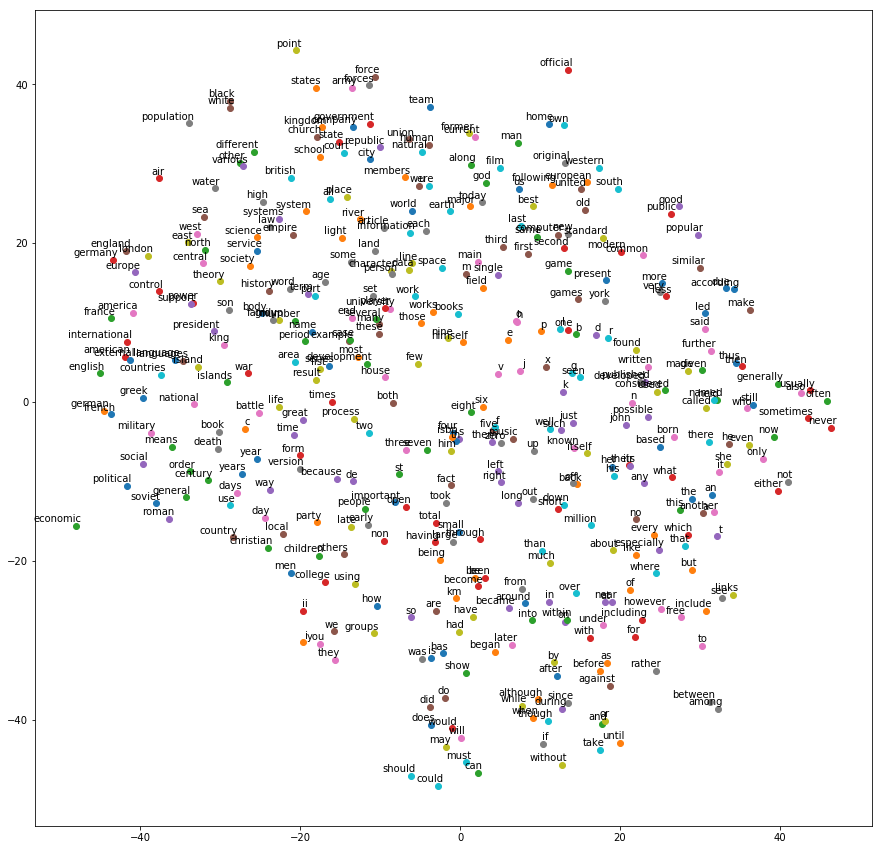

In [14]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)